# Лабораторная работа №3.
### Rapids и вычисления на GPU.

Проверим наличие графического ускорителя Tesla T4, P4, or P100.

In [1]:
!nvidia-smi

Tue May 12 20:15:40 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

Установим RAPIDS на виртуальную машину

In [1]:
# Install RAPIDS
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!bash rapidsai-csp-utils/colab/rapids-colab.sh stable

import sys, os

dist_package_index = sys.path.index('/usr/local/lib/python3.6/dist-packages')
sys.path = sys.path[:dist_package_index] + ['/usr/local/lib/python3.6/site-packages'] + sys.path[dist_package_index:]
sys.path
exec(open('rapidsai-csp-utils/colab/update_modules.py').read(), globals())

fatal: destination path 'rapidsai-csp-utils' already exists and is not an empty directory.
PLEASE READ
********************************************************************************************************
Changes:
1. Now that most people have migrated, we have rem0ved the migration notice.
2. default stable version is now 0.13.  Nightly is now 0.14
3. You can now declare your RAPIDS version as a CLI option and skip the user prompts (ex: '0.13' or '0.14', between 0.11 to 0.14, without the quotes): 
        "!bash rapidsai-csp-utils/colab/rapids-colab.sh <version/label>"
        Examples: '!bash rapidsai-csp-utils/colab/rapids-colab.sh 0.13', or '!bash rapidsai-csp-utils/colab/rapids-colab.sh stable', or '!bash rapidsai-csp-utils/colab/rapids-colab.sh s'
                  '!bash rapidsai-csp-utils/colab/rapids-colab.sh 0.14, or '!bash rapidsai-csp-utils/colab/rapids-colab.sh nightly', or '!bash rapidsai-csp-utils/colab/rapids-colab.sh n'
Enjoy using RAPIDS!
Starting to prep Colab for 

In [3]:
pip install open3d

     |████████████████████████████████| 4.9 MB 8.1 MB/s 
     |████████████████████████████████| 9.7 MB 41.6 MB/s 
     |████████████████████████████████| 2.2 MB 61.1 MB/s 
     |████████████████████████████████| 121 kB 68.7 MB/s 
     |████████████████████████████████| 170 kB 79.8 MB/s 
     |████████████████████████████████| 75 kB 4.9 MB/s 
     |████████████████████████████████| 118 kB 62.0 MB/s 
     |████████████████████████████████| 455 kB 58.5 MB/s 
     |████████████████████████████████| 1.1 MB 57.3 MB/s 
     |████████████████████████████████| 83 kB 2.1 MB/s 
     |████████████████████████████████| 106 kB 57.0 MB/s 
     |████████████████████████████████| 782 kB 54.5 MB/s 
     |████████████████████████████████| 56 kB 5.0 MB/s 
     |████████████████████████████████| 163 kB 69.7 MB/s 
     |████████████████████████████████| 151 kB 70.7 MB/s 
     |████████████████████████████████| 914 kB 51.1 MB/s 
     |████████████████████████████████| 1.1 MB 60.4 MB/s 
     |███████████████

In [0]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cudf
import open3d as o3d

from google.colab import files
from sklearn.feature_selection import SelectKBest, chi2
from cuml.preprocessing import train_test_split
from cuml import PCA
from cuml.svm import SVR
from cuml.ensemble import RandomForestRegressor, RandomForestClassifier
from cuml.metrics.regression import *
from cuml.metrics.accuracy import accuracy_score

from cuml import KMeans
from sklearn import cluster
import time

### 1.1 Прогнозирование свойства образца дизельного топлива по результатам спектрального анализа

Загрузим необходимые файлы

In [79]:
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving Metronidazole.xls to Metronidazole.xls
Saving qsar_oral_toxicity.csv to qsar_oral_toxicity.csv
User uploaded file "Metronidazole.xls" with length 6198272 bytes
User uploaded file "qsar_oral_toxicity.csv" with length 18505536 bytes


Импортируем данные


In [101]:
# Файл со свойствами дизельного топлива
prop_file = 'diesel_prop.csv'
# Файл с результатами спектрометрии
spec_file = 'diesel_spec.csv'

prop_cdf = cudf.io.read_csv(prop_file, usecols=[*range(1,9)], skiprows=8)
spec_cdf = cudf.io.read_csv(spec_file, usecols=[*range(1,403)], skiprows=9)
print(prop_cdf.head())
print(spec_cdf.head())

  Unnamed: 1   BP50    CN   D4052 FLASH FREEZE TOTAL  VISC
0      17366  230.0  55.1    null  null   null  null  1.98
1      17629  188.0  null  0.7818  52.0   null  null  1.16
2      19546   null  46.5  0.7883  null  -59.5  null  1.12
3      20573   null  53.6   0.851  85.0   -7.9  26.8  3.03
4      20622  217.0  null    null  63.0  -48.2  null  1.51
  Unnamed: 1       750       752       754  ...     1544     1546     1548     1550
0      17366 -0.028073 -0.025056 -0.020949  ...  0.93393  0.93160  0.92392  0.91500
1      17629 -0.027034 -0.023999 -0.019447  ...  0.90957  0.91360  0.90302  0.89997
2      19546 -0.024340 -0.021221 -0.016691  ...  0.93871  0.94011  0.92486  0.91992
3      20573 -0.021778 -0.018382 -0.014348  ...  1.07600  1.07920  1.06970  1.05460
4      20622 -0.022943 -0.019190 -0.014872  ...  1.07760  1.07940  1.06870  1.05250

[5 rows x 402 columns]


Удостоверимся в наличии или отсутствии пропусков в данных

In [102]:
prop_cdf.isnull().sum()

Unnamed: 1      0
BP50          389
CN            403
D4052         389
FLASH         389
FREEZE        389
TOTAL         389
VISC          389
dtype: int64

In [103]:
set(spec_cdf.isnull().sum())

{0}

Переименуем первый столбец (номер образца)

In [0]:
name_dict = {'Unnamed: 1': 'N_sample'}
prop_cdf.rename(mapper=name_dict, inplace=True)
spec_cdf.rename(mapper=name_dict, inplace=True)

Заполним пропуски в данных (датафрейм свойств ДТ) методом интерполяции

In [105]:
prop_pandas = prop_cdf.to_pandas()
prop_pandas.interpolate(limit_direction='both', inplace=True)
prop_cdf = cudf.from_pandas(prop_pandas)
prop_cdf.isnull().sum()

N_sample    0
BP50        0
CN          0
D4052       0
FLASH       0
FREEZE      0
TOTAL       0
VISC        0
dtype: int64

In [106]:
for col in prop_cdf.columns:
  print(prop_cdf[col].dtype)

object
float64
float64
float64
float64
float64
float64
float64


Удалим столбцы с номерами образцов и переопределим тип данных на *float32*

In [0]:
prop_cdf.drop_column('N_sample')
spec_cdf.drop_column('N_sample')

for col in prop_cdf.columns:
  prop_cdf[col] = prop_cdf[col].astype('float32')

for col in spec_cdf.columns:
  spec_cdf[col] = spec_cdf[col].astype('float32')

Сформируем множества входных и выходных данных

In [0]:
X_data = spec_cdf
Y_data = prop_cdf.VISC

Построим модель регрессии на основе метода опорных векторов

In [109]:
scores = []
svr_ = SVR()
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.2,random_state=7)
svr_.fit(X_train, Y_train)
y_preds = svr_.predict(X_test)
scores.append(svr_.score(X_test, Y_test))

for score in scores:
  print('Support Vector Regressor r2_score: %.3f' % score)

Support Vector Regressor r2_score: 0.078


Понизим размерность данных методом главных компонент и покажем долю дисперсии для каждой компоненты

In [110]:
pca_ = PCA(n_components=7, random_state=15)
XPCAreduced = pca_.fit_transform(X_data)

print('Explained variance ratio:\n')
for item in pca_._explained_variance_ratio_.to_output('numpy'):
    print('| {:.3f} |'.format(item))

Explained variance ratio:

| 0.696 |
| 0.200 |
| 0.068 |
| 0.022 |
| 0.006 |
| 0.003 |
| 0.002 |


Напишем класс, назначение которого схоже с классом *GridSearchCV* из библиотеки *sklearn.model_selection*.

In [0]:
class GridSearchCV:

  def __init__(self, estimator, param_grid, cv=None, random_state=0, shuffle=True, refit=True, refit_num=10, convert_dtype=False):
    if param_grid==None or type(param_grid)!=dict:
      raise ValueError('Set param_grid as a dict of parameters with multiple values')
    elif type(param_grid)==dict and len(param_grid)==0:
      raise ValueError('Dictionary param_grid is empty!')
    else:
      for v in param_grid.values():
        if len(v)==1:
          raise ValueError('Each parameter in param_grid must has multiple values!')
    
    self.estimator = estimator
    self.param_grid = param_grid
    self.cv = cv
    self.random_state = random_state
    self.shuffle = shuffle
    self.refit = refit
    self.refit_num = refit_num
    self.convert_dtype = convert_dtype

    self._isfitted = False
    self.fit_scores = None
    self.best_params = None
    self.best_estimator = None


  def fit(self, X, y):

    def get_params_from_grid(param_grid, ids):
      params = {}
      i = 0
      for k,v in param_grid.items():
        try:
          params[k] = v[ids[i]]
        except:
          params[k] = v
        i += 1
      return params

    def new_ids(ids, lim):
      l = len(ids)-1
      if ids[l]<lim[l]:
        ids[l] += 1
      else:
        ids = new(ids[:l], lim[:l])
        ids.append(0)
      return ids

    def train_and_refit(params):
      report = {}
      train_score = []
      test_score = []
      model = self.estimator
      model.set_params(**params)
      for i in range(self.refit_num):
        x1, x2, y1, y2 = train_test_split(X, y,\
                                          train_size=0.8,\
                                          shuffle=self.shuffle,\
                                          random_state=self.random_state)
        model.fit(x1, y1, convert_dtype=self.convert_dtype)
        train_score.append(model.score(x1, y1))
        test_score.append(model.score(x2, y2))

      train_score = np.asarray(train_score)
      test_score = np.asarray(test_score)
      report['train_score'] = train_score.mean()
      report['test_score'] = test_score.mean()
      return report

    def simple_train_test(params):
      report = {}
      x1, x2, y1, y2 = train_test_split(X, y,\
                                        train_size=0.8,\
                                        shuffle=self.shuffle,\
                                        random_state=self.random_state)
      model = self.estimator
      model.set_params(**params)
      model.fit(x1, y1, convert_dtype=self.convert_dtype)
      report['train_score'] = model.score(x1, y1)
      report['test_score'] = model.score(x2, y2)
      return report

    def cross_validation(params):
      return None

    def train_test(params):
      if self.cv == None:
        if self.refit == True:
          results = train_and_refit(params)
        else:
          results = simple_train_test(params)
      elif self.cv <= 1:
        raise ValueError('CV value must be higher than 1!')
      elif int(self.cv) != self.cv:
        raise ValueError('CV value must be integer!')
      else:
        results = cross_validation(params)
      return results

    def recur(param_grid, ids=None):
      if ids == None:
        ids = [0 for i in range(len(param_grid.keys()))]

      lim = [len(v)-1 for v in param_grid.values()]
      if ids==lim:
        return [train_test(get_params_from_grid(param_grid, ids))]
      else:
        vec = [train_test(get_params_from_grid(param_grid, ids))]
        ids = new_ids(ids, lim)
        vec.extend(recur(param_grid, ids))
        return vec

    def shape_scores(scores):
      prepared_scores = {}
      for k,v in scores[0].items():
        prepared_scores[k] = [d[k] for d in scores]
      return prepared_scores

    def get_best_params(fit_scores):
      param_grid = self.param_grid
      shape_ = [len(v) for v in param_grid.values()]
      reshaped_fit_scores = np.array(fit_scores['test_score']).reshape(shape_)
      try:
        metric = self.estimator.accuracy_metric
      except:
        metric = ''
      if ('mse' in metric) or ('mae' in metric):
        ids_ = np.where(reshaped_fit_scores==reshaped_fit_scores.min())
      else:
        ids_ = np.where(reshaped_fit_scores==reshaped_fit_scores.max())
      ids_ = [i[0] for i in ids_]
      
      best_params = {}
      i = 0
      for k,v in param_grid.items():
        best_params[k] = v[ids_[i]]
        i += 1
      return best_params

    def get_best_estimator(best_params):
      x1, x2, y1, y2 = train_test_split(X, y,\
                                        train_size=0.8,\
                                        shuffle=self.shuffle,\
                                        random_state=self.random_state)
      model = self.estimator
      model.set_params(**best_params)
      model.fit(x1, y1, convert_dtype=self.convert_dtype)
      return model

    scores = recur(self.param_grid)
    self.fit_scores = shape_scores(scores)
    self.best_params = get_best_params(self.fit_scores)
    self.best_estimator = get_best_estimator(self.best_params)
    self._isfitted = True

Проведём подбор гипер параметров *RandomForestRegressor* последовательно: сначала количества базовых деревьев, потом максимальной глубины деревьев.

Best parameters:  {'n_estimators': 65} 
R2 score:  0.3253329396247864
Best parameters:  {'max_depth': 5}
Random Forest Regressor MSE: 0.123 
Random Forest Regressor MAE: 0.253 
Random Forest Regressor R2-score: 0.448


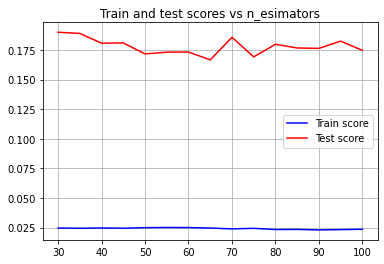

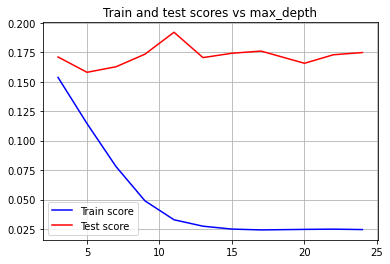

In [112]:
X_train, X_test, Y_train, Y_test = train_test_split(XPCAreduced, Y_data, train_size=0.8, random_state=7)

# Инициализируем нашу модель
rfr = RandomForestRegressor(seed=10)

# Зададим набор значений числа базовых моделей n_estimators
rng = range(30,105,5)
forest_params = {'n_estimators': rng}

# Инициализируем и проведём поиск лучшего числа базовых деревьев
forest_grid = GridSearchCV(estimator=rfr, param_grid=forest_params, random_state=5)
forest_grid.fit(X_train, Y_train)
rfr = forest_grid.best_estimator

# Выведем результаты обучения и тестирования
train_score = forest_grid.fit_scores['train_score']
test_score = forest_grid.fit_scores['test_score']
x = rng

plt.figure()
plt.plot(x, train_score, "b", label='Train score')
plt.plot(x, test_score, "r", label='Test score')
ttl = 'Train and test scores vs n_esimators'
plt.title(ttl)
plt.legend()
plt.grid(True)

print('Best parameters: ', forest_grid.best_params)

# Повторим эксперимент, зафиксируем число базовых моделей n_estimators
# и зададим значения глубины дерева max_depth
rng =  [3, 5, 7, 9, 11, 13, 15, 17, 20, 22, 24]
forest_params = {'max_depth': rng}

# Инициализируем и проведём поиск лучшего значения максимальной глубины дерева
forest_grid = GridSearchCV(estimator=rfr, param_grid=forest_params, random_state=5)
forest_grid.fit(X_train, Y_train)
rfr = forest_grid.best_estimator

# Выведем результаты обучения и тестирования
train_score = forest_grid.fit_scores['train_score']
test_score = forest_grid.fit_scores['test_score']
x = rng

plt.figure()
plt.plot(x, train_score, "b", label='Train score')
plt.plot(x, test_score, "r", label='Test score')
ttl = 'Train and test scores vs max_depth'
plt.title(ttl)
plt.legend()
plt.grid(True)

print('Best parameters: ', forest_grid.best_params)

# Оценим качество полученной модели:
rfr_quality = [mean_squared_error(Y_test, rfr.predict(X_test)),
               mean_absolute_error(Y_test, rfr.predict(X_test)),
               r2_score(Y_test, rfr.predict(X_test))]
print('Random Forest Regressor MSE: %.3f' % rfr_quality[0],
      '\nRandom Forest Regressor MAE: %.3f' %  rfr_quality[1],
      '\nRandom Forest Regressor R2-score: %.3f' % rfr_quality[2])

Как видно из графиков, параметр *max_depth* хорошо регуляризует исходную модель. Значение коэффициента детерминации говорит о том, что модель объясняет ~45% невязок. 

### 1.2 Идентификация контрафактной продукции по результатам спектроскопии образцов лекарственного препарата

Так как целевых класса только два, то имеем задачу бинарной классификации.
Импортируем данные

In [0]:
medicine_file = 'Metronidazole.xls'
med_df = pd.read_excel(medicine_file, sheet_name='Metronidazole_Data')
med_cdf = cudf.from_pandas(med_df)
med_cdf.drop_column('Unnamed: 0')

Транспонируем датафрейм для приведения данных к виду *n_samples* : *n_features*.
Здесь *n_samples* - образцы лекарства, *n_features* - результаты спектрального анализа

In [0]:
med_cdf = med_cdf.transpose()

Понизим размерность данных методом главных компонент и покажем долю дисперсии для каждой компоненты

In [115]:
pca_ = PCA(n_components=6, random_state=15)
med_cdf_reduced = pca_.fit_transform(med_cdf)

print('Explained variance ratio:\n')
for item in pca_._explained_variance_ratio_.to_output('numpy'):
    print('| {:.3f} |'.format(item))

Explained variance ratio:

| 0.867 |
| 0.108 |
| 0.013 |
| 0.008 |
| 0.003 |
| 0.001 |


Удалим столбцы с номерами образцов и переопределим тип данных на *float32*

In [0]:
for col in med_cdf_reduced.columns:
  med_cdf_reduced[col] = med_cdf_reduced[col].astype('float32')

Введём целевой столбец: подделку обозначим "1", оригинал - "0"

In [0]:
target = [1 if r'F' in idx else 0 for idx in med_cdf.index]
med_cdf_reduced['target'] = target

Разделим данные на множество описаний образцов X_cl и множество классов Y_cl

In [0]:
X_cl = med_cdf_reduced.drop(columns='target')
Y_cl = med_cdf_reduced['target'].astype('int32')

Разделим полученные множества на тренировочное и тестовое подмножества

In [0]:
train_index = list(range(2,90))
test_index = list(set(range(len(Y_cl)))-set(train_index))
X2_train, X2_test, Y2_train, Y2_test = X_cl.iloc[train_index, :], X_cl.iloc[test_index, :], Y_cl[train_index], Y_cl[test_index]

Проведём подбор гипер параметров *RandomForestClassifier* последовательно: сначала количества базовых деревьев, потом максимальной глубины деревьев.

Best parameters:  {'n_estimators': 5}
Best parameters:  {'max_depth': 5}
Random Forest Classifier accuracy: 1.000


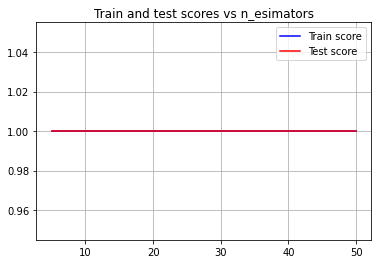

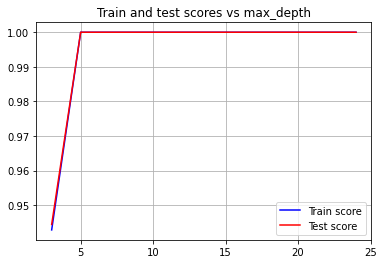

In [126]:
# Инициализируем нашу модель
rfc = RandomForestClassifier(seed=10)

# Зададим набор значений числа базовых моделей n_estimators
rng = range(5,55,5)
forest_params = {'n_estimators': rng}

# Инициализируем и проведём поиск лучшего числа базовых деревьев
forest_grid = GridSearchCV(estimator=rfc, param_grid=forest_params, random_state=5)
forest_grid.fit(X2_train, Y2_train)
rfc = forest_grid.best_estimator

# Выведем результаты обучения и тестирования
train_score = forest_grid.fit_scores['train_score']
test_score = forest_grid.fit_scores['test_score']
x = rng

plt.figure()
plt.plot(x, train_score, "b", label='Train score')
plt.plot(x, test_score, "r", label='Test score')
ttl = 'Train and test scores vs n_esimators'
plt.title(ttl)
plt.legend()
plt.grid(True)

print('Best parameters: ', forest_grid.best_params)

# Повторим эксперимент, зафиксируем число базовых моделей n_estimators
# и зададим значения глубины дерева max_depth
rng =  [3, 5, 7, 9, 11, 13, 15, 17, 20, 22, 24]
forest_params = {'max_depth': rng}

# Инициализируем и проведём поиск лучшего значения максимальной глубины дерева
forest_grid = GridSearchCV(estimator=rfc, param_grid=forest_params, random_state=5)
forest_grid.fit(X2_train, Y2_train)
rfc = forest_grid.best_estimator

# Выведем результаты обучения и тестирования
train_score = forest_grid.fit_scores['train_score']
test_score = forest_grid.fit_scores['test_score']
x = rng

plt.figure()
plt.plot(x, train_score, "b", label='Train score')
plt.plot(x, test_score, "r", label='Test score')
ttl = 'Train and test scores vs max_depth'
plt.title(ttl)
plt.legend()
plt.grid(True)

print('Best parameters: ', forest_grid.best_params)

# Оценим качество полученной модели:
rfc_accuracy = accuracy_score(Y2_test, rfc.predict(X2_test))
print('Random Forest Classifier accuracy: %.3f' % rfc_accuracy)

In [127]:
rfc_accuracy = accuracy_score(Y_cl, rfc.predict(X_cl))
print('Random Forest Classifier accuracy: %.3f' % rfc_accuracy)

Random Forest Classifier accuracy: 1.000


Здесь *RandomForestClassifier* справился аналогично модели из лабораторной работы 2 на "отлично".

### 1.3 Идентификация токсичности вещества на основе данных о присутствии/отсутствии молекулярных маркеров

Так как целевых класса только два, то имеем задачу бинарной классификации.
Импортируем данные

In [0]:
toxic_file = 'qsar_oral_toxicity.csv'
toxic_df = pd.read_csv(toxic_file, header=None, sep=None)
toxic_cdf = cudf.from_pandas(toxic_df)

Обозначим положительные результаты (очень токсичное вещество) "1", отрицательные (нетоксичное вещество) - "0"

In [0]:
toxic_cdf[1024] = [1 if r'pos' in s else 0 for s in toxic_df[1024].values]

Удалим столбцы с номерами образцов и переопределим тип данных на *float32*

In [0]:
for col in toxic_cdf.columns:
  toxic_cdf[col] = toxic_cdf[col].astype('float32')

Разделим множества признаков и классов на тренировочное и тестовое подмножества

In [0]:
X_cl = toxic_cdf.drop([1024], axis=1)
Y_cl = toxic_cdf[1024]

Выберем признаки в соответствии с самой высокой значимостью, в качестве критерия - Хи-квадрат
(в итоге мы понизим размерность исходных данных в ~10 раз)

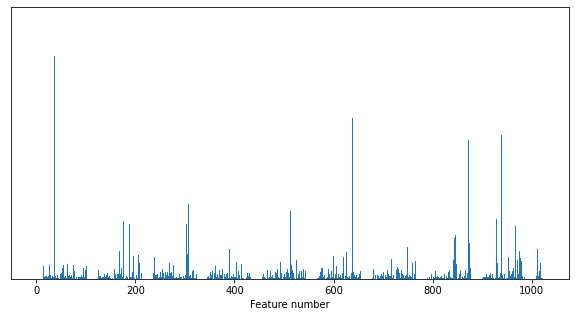

In [203]:
sel= SelectKBest(chi2, k=100)
X_cl_reduced = sel.fit_transform(X_cl.to_pandas(), Y_cl.to_pandas())
X_cl_reduced = pd.DataFrame(data=X_cl_reduced)
X_cl_reduced = cudf.from_pandas(X_cl_reduced)

scores = -np.log10(sel.pvalues_)
scores /= scores.max()

# Построим столбчатую диаграмму по всем признакам
plt.figure(figsize=[10,5])
plt.bar(X_cl.columns, scores)
plt.xlabel('Feature number')
plt.yticks(())
plt.axis('tight')
plt.show()

# Сформируем тренировочные и тестовые наборы из датасета с пониженной размерностью
X3_train, X3_test, Y3_train, Y3_test = train_test_split(X_cl_reduced, Y_cl, test_size=0.2, random_state=7)

Проведём подбор гипер параметров *RandomForestClassifier* последовательно: сначала количества базовых деревьев, потом максимальной глубины деревьев.

Best parameters:  {'n_estimators': 70}
Best parameters:  {'max_depth': 22}
Random Forest Classifier accuracy: 0.930


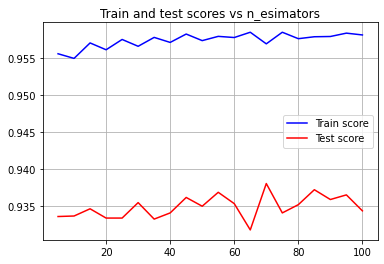

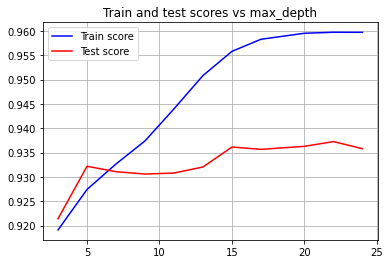

In [204]:
# Инициализируем нашу модель
rfc = RandomForestClassifier(seed=10)

# Зададим набор значений числа базовых моделей n_estimators
rng = range(5,105,5)
forest_params = {'n_estimators': rng}

# Инициализируем и проведём поиск лучшего числа базовых деревьев
forest_grid = GridSearchCV(estimator=rfc, param_grid=forest_params, random_state=5, convert_dtype=True)
forest_grid.fit(X3_train, Y3_train)
rfc = forest_grid.best_estimator

# Выведем результаты обучения и тестирования
train_score = forest_grid.fit_scores['train_score']
test_score = forest_grid.fit_scores['test_score']
x = rng

plt.figure()
plt.plot(x, train_score, "b", label='Train score')
plt.plot(x, test_score, "r", label='Test score')
ttl = 'Train and test scores vs n_esimators'
plt.title(ttl)
plt.legend()
plt.grid(True)

print('Best parameters: ', forest_grid.best_params)

# Повторим эксперимент, зафиксируем число базовых моделей n_estimators
# и зададим значения глубины дерева max_depth
rng =  [3, 5, 7, 9, 11, 13, 15, 17, 20, 22, 24]
forest_params = {'max_depth': rng}

# Инициализируем и проведём поиск лучшего значения максимальной глубины дерева
forest_grid = GridSearchCV(estimator=rfc, param_grid=forest_params, random_state=5, convert_dtype=True)
forest_grid.fit(X3_train, Y3_train)
rfc = forest_grid.best_estimator

# Выведем результаты обучения и тестирования
train_score = forest_grid.fit_scores['train_score']
test_score = forest_grid.fit_scores['test_score']
x = rng

plt.figure()
plt.plot(x, train_score, "b", label='Train score')
plt.plot(x, test_score, "r", label='Test score')
ttl = 'Train and test scores vs max_depth'
plt.title(ttl)
plt.legend()
plt.grid(True)

print('Best parameters: ', forest_grid.best_params)

# Оценим качество полученной модели:
rfc_accuracy = accuracy_score(Y3_test, rfc.predict(X3_test))
print('Random Forest Classifier accuracy: %.3f' % rfc_accuracy)

Видим, что лучший результат по точности из лабораторной работы 2 достигнут.

# 2. Уменьшение числа оттенков в изображении

In [3]:
files.upload()

Saving dodge-challenger-hellcat-srt-austins.jpg to dodge-challenger-hellcat-srt-austins.jpg


{'dodge-challenger-hellcat-srt-austins.jpg': b'\xff\xd8\xff\xe1\x18\x00Exif\x00\x00II*\x00\x08\x00\x00\x00\x0f\x00\x00\x01\x03\x00\x01\x00\x00\x00@\x14\x00\x00\x01\x01\x03\x00\x01\x00\x00\x00\x80\r\x00\x00\x02\x01\x03\x00\x03\x00\x00\x00\xc2\x00\x00\x00\x06\x01\x03\x00\x01\x00\x00\x00\x02\x00\x00\x00\x0f\x01\x02\x00\x06\x00\x00\x00\xc8\x00\x00\x00\x10\x01\x02\x00\x14\x00\x00\x00\xce\x00\x00\x00\x12\x01\x03\x00\x01\x00\x00\x00\x01\x00\x00\x00\x15\x01\x03\x00\x01\x00\x00\x00\x03\x00\x00\x00\x1a\x01\x05\x00\x01\x00\x00\x00\xe2\x00\x00\x00\x1b\x01\x05\x00\x01\x00\x00\x00\xea\x00\x00\x00(\x01\x03\x00\x01\x00\x00\x00\x02\x00\x00\x001\x01\x02\x00\x1e\x00\x00\x00\xf2\x00\x00\x002\x01\x02\x00\x14\x00\x00\x00\x10\x01\x00\x00;\x01\x02\x00\t\x00\x00\x00$\x01\x00\x00i\x87\x04\x00\x01\x00\x00\x000\x01\x00\x00l\x03\x00\x00\x08\x00\x08\x00\x08\x00Canon\x00Canon EOS REBEL T4i\x00`\xe3\x16\x00\x10\'\x00\x00`\xe3\x16\x00\x10\'\x00\x00Adobe Photoshop CS6 (Windows)\x002016:01:24 21:38:38\x00SNAPSEED\x00\x0

In [0]:
src_file = "dodge-challenger-hellcat-srt-austins.jpg"
src_img = o3d.io.read_image(src_file)

In [0]:
def np2cudf(df):
    df = pd.DataFrame({'fea%d'%i:df[:,i] for i in range(df.shape[1])})
    pdf = cudf.DataFrame()
    for c,column in enumerate(df):
      pdf[str(c)] = df[column]
    return pdf

def Reshape(img):
    np_img = np.asarray(img, dtype=np.float32)
    vsize = len(np_img)
    hsize = len(np_img[0])
    np_img = np.vstack(np_img)
    return np_img, vsize, hsize

Преобразуем изображение в матрицу [*n_pixels*, 3], где строки представлены пикселями, а столбцы - значениями интенсивности цвета: красный 0-255, зелёный 0-255, синий 0-255.

In [0]:
np_img, vsize, hsize = Reshape(src_img)
cdf_img = np2cudf(np_img)

Выполним кластеризацию на 8, 16, 32, 64 и 128 кластеров методом *k-means*,
что соответствует глубине цвета 8, 16, 32, 64 и 128 бит. При этом используем две функции: одну из библиотеки *sklearn.cluster*, вторую - из *cuml* - и посмотрим, где вычисления прошли быстрее.

In [9]:
nums = [2**x for x in range(3,8)]
stop = len(nums)

start = time.time()
kmeans_gpu = [KMeans(n_clusters=num).fit(cdf_img) for num in nums]
print('Clustering completed')

end = time.time()
print(end - start)

Clustering completed
29.527414798736572


В тесте функции из библиотеки *sklearn.cluster* не удалось замерить время, так как программа выполнялась слишком долго, таким образом, техническая победа метода на графическом ускорителе.